# Load and prepare the data

## Import librairies

In [96]:
import requests
import tweepy
import webbrowser
import os

import pandas as pd

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import string
import unidecode

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import display, Image

## Import keys

In [2]:
from raw_data import keys

In [3]:
twitter_api_key = keys.twitter_api_key()
twitter_api_secret_key = keys.twitter_api_key_secret()
twitter_bearer_token = keys.twitter_bearer_token

## Connect my developer project to my twitter profile

In [4]:
callback_uri = "oob" # url
auth = tweepy.OAuthHandler(twitter_api_key, twitter_api_secret_key, callback_uri)
redirect_url = auth.get_authorization_url()
print(redirect_url)

https://api.twitter.com/oauth/authorize?oauth_token=uA6grwAAAAABUe3MAAABfSzVxoQ


In [5]:
m=

SyntaxError: invalid syntax (1928120398.py, line 1)

In [5]:
user_pin_value = '5673118'
auth.get_access_token(user_pin_value)
api = tweepy.API(auth)

## Load new content

### Function to extract the tweets of politicals that I follow

In [6]:
def extract_tweets_from_politics(number_of_tweet_per_politic):
    """This function return a DataFrame of the last tweets of politics that I follow on Twitter"""
    
    # Start by working on my own account
    me = api.get_user(screen_name="alecoursonnois")
    # Generate a list of my all of my friends (considering that I have under 50 friends on twitter)
    my_friends = me.friends(count=50)
    
    # Retrieve my personal friends which I don't want to analyze their tweets
    not_politics = ["alecoursonnois", "Baly_5", "LucieCMP", "JeannonoSmith", "Seezzy_"]
    
    # Create a set to stock the DataFrame columns names
    columns = set()
    # Create a list to save each tweet and its datas
    tweets_data = []
    # Create to save politics screen_names
    politics_screen_name = []
    
    # Iterate on my_friends
    for friend in my_friends:
        friend_name = friend.screen_name
        
        # Don't act if this friend is out of the project
        if friend_name in not_politics:
            pass
        
        else:
            # Generate politics timeline list of the last tweets (the number must be indicated as a function's argument)
            timeline_list = api.get_user(screen_name=friend_name).timeline(count=number_of_tweet_per_politic, tweet_mode="extended")
            
            # Iterate on each tweet
            for status in timeline_list:
                # Generate a dictionary of status attributes
                status_dict = dict(vars(status))
                
                # From this dictionary, get the keys and stock it in a variable
                keys = vars(status).keys()
                
                # Create a dictionary stocking each status of the politic we are working on
                # This dictionary will be added to the "tweets_data" list and finaly convert into a DataFrame
                single_tweet_data = {}
    
                # Iterate on each status key (future column name)
                for k in keys:
                    # Add the status data to its right key into the dictionary of each status
                    single_tweet_data[k] = status_dict[k]
                    # Add the key as a column name in the set
                    columns.add(k)
                
                # Append the full single_tweet_data dictionary with the right key to the tweets_data list
                tweets_data.append(single_tweet_data)

    # Give a name to the columns respecting the order
    headers_cols = list(columns)

    # Allow the DataFrame to display full tweets when printed
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    
    # Convert the tweets_data list into a DataFrame
    df = pd.DataFrame(tweets_data)
    
    # Only keep columns that provides information
    columns_to_keep = ['id', '_json', 'source', 'source_url', 'retweet_count']
    df = df[columns_to_keep]
    
    # Generate new features from extracted data
    df["user"] = df["_json"].apply(lambda x : x["user"]["screen_name"])
    df["created_date"] = pd.to_datetime(df["_json"].apply(lambda x : x["created_at"])).dt.strftime("%Y-%m-%d")
    df["created_hour"] = pd.to_datetime(df["_json"].apply(lambda x : x["created_at"])).dt.strftime("%H:%M:%S")
    df["text"] = df["_json"].apply(lambda x : x["full_text"])
    df["hashtags"] = df["_json"].apply(lambda x : [hasthstags["text"] for hasthstags in x["entities"]["hashtags"]])
    
    # Reorder columns
    right_order = ["user", "id", "source", "text", "created_date", "created_hour", "hashtags", "retweet_count"]
    df = df[right_order]
    
    return df

### Apply the function

In [7]:
# Load new tweets
last_tweets_df = extract_tweets_from_politics(number_of_tweet_per_politic=250)
last_tweets_df.shape

(8125, 8)

### Add features

#### Generate new_features

In [239]:
new_features = [{"user":'EPhilippe_LH', "name": "Édouard Philippe","political_party":"Horizons", "political_trend":"droite"},
                 {"user":'ZemmourEric', "name": "Eric Zemmour", "political_party":"Aucun", "political_trend":"extrême_droite"},
                 {"user":'EmmanuelMacron', "name": "Emmanuel Macron", "political_party":"La République En Marche", "political_trend":"droite"},
                 {"user":'Waechter2022', "name": "Antoine Waechter", "political_party":"Mouvement Ecologiste Independant", "political_trend":"ecologie"},
                 {"user":'Fabien_Roussel', "name": "Fabien Roussel", "political_party":"Parti Communiste Français", "political_trend":"extrême_gauche"},
                 {"user":'PhilippePoutou', "name": "Philippe Poutou", "political_party":"Nouveau Parti Anticapitaliste", "political_trend":"extrême_gauche"},
                 {"user":'jfpoisson78', "name": "Jean-Frédéric Poisson", "political_party":"La Voie du Peuple", "political_trend":"extrême_droite"},
                 {"user":'f_philippot', "name": "Florian Philippot", "political_party":"Les Patriotes", "political_trend":"extrême_droite"},
                 {"user":'vpecresse', "name": "Valérie Pécresse", "political_party":"Soyons Libres", "political_trend":"droite"},
                 {"user":'DenisPayre', "name": "Denis Payre", "political_party":"Les Républicains", "political_trend":"droite"},
                 {"user":'montebourg', "name": "Arnaud Montebourg", "political_party":"L'Engagement", "political_trend":"gauche"},
                 {"user":'JLMelenchon', "name": "Jean-Luc Mélenchon", "political_party":"La France Insoumise", "political_trend":"extrême_gauche"},
                 {"user":'MLP_officiel', "name": "Marine Le Pen", "political_party":"Front National", "political_trend":"extrême_droite"},
                 {"user":'SLeFoll', "name": "Stéphane Le Foll", "political_party":"Parti Socialiste", "political_trend":"gauche"},
                 {"user":'jeanlassalle', "name": "Jean Lassale", "political_party":"Résistons", "political_trend":"divers"},
                 {"user":'larrouturou', "name": "Pierre Larrouturou", "political_party":"Nouvelle Donne", "political_trend":"gauche"},
                 {"user":'philippejuvin', "name": "Philippe Juvin", "political_party":"Les Républicains", "political_trend":"droite"},
                 {"user":'yjadot', "name": "Yannick Jadot", "political_party":"Europe Ecologie-Les Verts", "political_trend":"ecologie"},
                 {"user":'Anne_Hidalgo', "name": "Anne Hidalgo", "political_party":"Parti Socialiste", "political_trend":"gauche"},
                 {"user":'gerardfiloche', "name": "Gerard Filoche", "political_party":"La Gauche Démocratique et Sociale", "political_trend":"extrême_gauche"},
                 {"user":'dupontaignan', "name": "Nicolas Dupont-Aignan", "political_party":"Debout la France", "political_trend":"extrême_droite"},
                 {"user":'ECiotti', "name": "Eric Ciotti", "political_party":"Les Républicain", "political_trend":"droite"},
                 {"user":'xavierbertrand', "name": "Xavier Bertrand", "political_party":"La Manufacture", "political_trend":"droite"},
                 {"user":'MichelBarnier', "name": "Michel Barnier", "political_party":"Les Républicains", "political_trend":"droite"},
                 {"user":'UPR_Asselineau', "name": "François Asselineau", "political_party":"Union Populaire Républicaine", "political_trend":"divers"},
                 {"user":'n_arthaud', "name": "Nathalie Arthaud", "political_party":"Lutte Ouvrière", "political_trend":"extrême_gauche"},
                 {"user":'MartinRocca2022', "name": "Martin Rocca", "political_party":"Constituante 2022", "political_trend":"divers"},
                 {"user":'gilleslazzarini', "name": "Gilles Lazzarini", "political_party":"Parti Politique pour la Paix et la Protection de la Planète", "political_trend":"divers"},
                 {"user":'AlexLanglois_', "name": "Alex Langlois", "political_party":"Refondation 2022", "political_trend":"divers"},
                 {"user":'luclaf', "name": "Luc Laforets", "political_party":"Une Perspective - la 6e République", "political_trend":"divers"},
                 {"user":'Vukuzman', "name": "Georges Kuzmanovic", "political_party":"République Souveraine", "political_trend":"divers"},
                 {"user":'FabriceGrimal', "name": "Fabrice Grimal", "political_party":"La Concorde Citoyenne 2022", "political_trend":"divers"},
                 {"user":'ClaraEgger1', "name": "Clara Egger", "political_party":"Espoir RIC 2022", "political_trend":"divers"},
                 {"user":'Cau_Marie_', "name": "Marie Cau", "political_party":"Sans Etiquette", "political_trend":"divers"},
                 {"user":'antoine27955080', "name": "Antoine Martinez", "political_party":"Volontaires pour la France", "political_trend":"extrême_droite"},
                 {"user":'regis_ollivier', "name": "Régis Ollivier", "political_party":"Indépendant", "political_trend":"droite"},
                 {"user":'JaclineMouraud', "name": "Jacline Mouraud", "political_party":"Sans Etiquette", "political_trend":"droite"},
                 {"user":'HeleneThouy', "name": "Hélène Thouy", "political_party":"Parti Animaliste", "political_trend":"ecologie"},
                 {"user":'MAZUEL_Pace', "name": "Philippe Mazuel", "political_party":"Pace", "political_trend":"gauche"},
                 {"user":'MarCharlott', "name": "Charlotte Marchandise", "political_party":"Sans Etiquette", "political_trend":"gauche"},
                 {"user":'AguebPorterie', "name": "Anna Agueb-Porterie", "political_party":"Aucun", "political_trend":"gauche"},
                 {"user":'AnasseKazib', "name": "Anasse Kazib", "political_party":"Courant Communiste Révolutionnaire-Révolution Permanente", "political_trend":"extrême_gauche"},
                 {"user":'Stauthui', "name": "Stéphane Tauthui", "political_party":"Tous France", "political_trend":"droite"},
                 {"user":'GildasVieira', "name": "Gildas Vieira", "political_party":"La France autrement", "political_trend":"divers"},]

In [9]:
new_features_df = pd.DataFrame(new_features)

#### Merge it to last_tweets_df

In [10]:
# because M Rocca changed his accounts name we must change our informations
last_tweets_df["user"] = last_tweets_df["user"].str.replace("MartinRocca12", "MartinRocca2022")

In [11]:
last_tweets_df = pd.merge(left=last_tweets_df, right=new_features_df, on='user', how='left')

### Check the number of tweets per politics

In [ ]:
# last_tweets_df["user"].value_counts()

### Add it to the main global DataFrame

#### Load the global_df 
- and drop the last index column automatically named "Unamed: 0" when saving df to csv file

In [12]:
global_df = pd.read_csv("global_df.csv").drop(columns="Unnamed: 0")

#### Add new content

In [13]:
actual_number_of_tweets = global_df.shape[0]

# Append last tweets loaded to our archives
global_df = global_df.append(last_tweets_df, ignore_index=True)

# Sort the df by retweet_count to be sure to only keep the last update of retweet_count
global_df = global_df.sort_values('retweet_count', ascending=False).drop_duplicates(["user", "id", "source", "text", "created_date", "created_hour", "name", "political_party","political_trend"])

print(f"We just added {global_df.shape[0]-actual_number_of_tweets} tweets to our global_df")

We just added 56 tweets to our global_df


#### Save the new global_df

In [14]:
global_df.shape

(12183, 11)

In [15]:
global_df["user"] = global_df["user"].str.replace("MartinRocca12", "MartinRocca2022")

In [243]:
global_df.to_csv("global_df.csv")

## Clean tweets

### Make a new df from the global one
- This way we will be allowed to drop duplicates next time we will load the global_df from the csv file

In [120]:
df_ready_for_nlp = global_df.copy()

### Retrieve recurrent regex

#### Retweets

In [18]:
def retrieve_rt_retweets(df):
    new_texts = []
    
    for text in df["text"]:
        if text[:3] == 'RT ' or text[:3] == 'rt ':
            new_texts.append(text[3:])
        else:
            new_texts.append(text)
    
    df["text"] = new_texts
    
    return df

In [121]:
df_ready_for_nlp = retrieve_rt_retweets(df_ready_for_nlp)

#### Links

In [20]:
def retrieve_links(df):
    pattern = re.compile("https://*")
    new_text = []

    for text in df["text"]:
        if re.search(pattern, text) is None:
            new_text.append(text)
        else:
            match_position = re.search(pattern, text).span()[0]
            new_text.append(text[:(match_position-1)])

    df["text"] = new_text
    
    return df

In [122]:
df_ready_for_nlp = retrieve_links(df_ready_for_nlp)


### Retrieve punctuation, lower text, tokenize, stopwords

#### Define a text_cleaner function

In [22]:
def text_cleaner(text):
    # Remove Punctuation
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') 
    
    # Lower Case
    lowercased = text.lower() 
    
    # Remove accents
    unaccented_string = unidecode.unidecode(lowercased) 
    
    # Tokenize
    tokenized = word_tokenize(unaccented_string) 
    
    # Remove numbers
    words_only = [word for word in tokenized if word.isalpha()] 
    
    # Make stopword list
    stop_words = set(stopwords.words('french')) 
    
    # Remove Stop Words
    without_stopwords = [word for word in words_only if not word in stop_words]
    
    return " ".join(without_stopwords)

#### Apply the text_cleaner function

In [123]:
df_ready_for_nlp['text'] = df_ready_for_nlp['text'].apply(text_cleaner)

## Analyze tweets

### Find lexical themes and store their vocabulary in lists

In [24]:
political_lexicon_before_tokenize = """Zinoviev,Yougoslavie,yougoslave,vouseteslarepublique,volonté,vision,vietnamien,Vietnam,Varsovie,utopie,URSS,univers,union,UEC,Twitter,trotskyste,trotskysme,Trotsky,trotskiste,trotskisme,Trotski,troïka,tribalisme,électionprésidentielle,DébatdelaDroite,DebatDeLaDroite,testspayants,Talibans,Solidaritepalestine,Socialistes,russie,RépubliqueEuropéenne,RepubliqueEuropeenne,RentreeLR,Régionales,regionales,primaireLR,Présidentielle2022,conseilconstitutionnel,totalitarisme,totalitaire,Tito,titiste,titisme,Thucydide,Thorez,termite,temporisation,tempête,technocratie,technocrate,Tchéka,Tchécoslovaquie,tchécoslovaque,Tchang,Taïwan,tabou,système,syndicalisme,sympathisant,stratification,stratégie,staliniste,stalinisme,stalinien,Staline,sphère,spartakiste,soviétomane,soviétique,soviet,souverainiste,souverainisme,souveraineté,Solidarnosc,solidarité,sociologue,sociologique,sociologie,sociolecte,société,sociétal,socialiste,socialisme,socialisation,sociales,sociale,social,sociable,sociabilité,situation,sionisme,siège,Shanghai,SFIO,séparatiste,sentiment,sénat,secrétaire,sécession,scolaire,scission,schisme,Schengen,scandale,samu,samizdat,ruse,RPC,Rousseau,Roumanie,rouge,révolutionnaire,révolution,restauration,responsabilité,respect,résistant,résistance,réseautage,république,républicain,religion,rejet,réinsertion,régime,réfugié,réformiste,réforme,réflexion,réactionnaire,réaction,RDA,rapport,rang,racial,querelles,qualité,publiciste,public,psychologique,psychique,province,protectorat,propagande,prolétarienne,progressiste,progressisme,progrès,programmes,programme,problèmes,Primaire,pression,présidium,Presidentielles2022,Presidentielle2022,Présidentielle,Presidentielle,prélèvement,Pravda,pouvoir,postcommunisme,populiste,populisme,populaire,politologue,politologie,politiste,politiser,politisation,politiquement,politique,politicien,politicard,politicaillerie,politicailler,politburo,polémique,pluralisme,plan,philosophique,philosophie,philosophe,phénomènes,personnalités,perestroïka,Pékin,PCUS,PCI,pauvre,patriarcat,partisan,parti,partenaire,partageux,parlementarisme,parlementaire,parlement,parenté,paradigme,panslavisme,panafricanisme,pamphlet,palestinien,pacte,orthodoxe,orientation,opposant,opinion,ONG,oligarchie,office,notion,nomenklatura,noblesse,nivellement,nihilisme,négociation,nationalité,nationaliste,nationalisme,nationalisation,nationale,nation,mutualité,Municipales,municipale,multipartisme,moscoutaire,Moscou,moralité,morales,morale,moral,mondialisation,monarchiste,monarchie,mœurs,modéré,modèle,mixité,ministère,militant,milieu,méritocratie,menées,Libertés,LibertéEtResponsabilité,GiletsJaunes,GiletsJaune,Frexit,Election2022,DiplomatiePacifique,ConseilDeParis,CongrèsLR,CongresLR,CommunedeParis,Citoyens,BilanDeLaHonte,Berlin,école,média,Mauss,matriarcat,marchais,maoïste,maoïsme,Mao,Malenkov,majorité,machiavélisme,machiavélique,Machiavel,maccarthysme,lutte,logement,locatif,littérature,liens,liberté,libertaire,libération,libéral,liant,léniniste,léninisme,Lénine,légitimité,légitimation,leader,LCR,langue,laïcité,Kuomintang,KPD,Komintern,Kominform,Khrouchtchev,Kampuchéa,justice,juridique,Juppé,junte,journal,Jiangxi,isolationnisme,islamisme,Irak,intrigues,interventionnisme,interpellation,internationaliste,internationale,intérieure,intérêts,interaction,intellectuel,intégration,institutions,institutionnel,institution,instabilité,insertion,infléchir,inégalité,indochinois,individuel,individualiste,individu,indépendantiste,indépendantisme,indépendance,impérialiste,impérialisme,immigration,idéologique,idéologie,identité,identitaire,idéal,humain,Hoxha,Hobbes,HLM,histoire,hiérarchie,habitus,habitude,habitat,habitant,habileté,Guomindang,guérilla,Guépéou,groupes,grégaire,gouverner,gouvernementale,gouvernement,gouvernant,Gottwald,Gorbatchev,glasnost,géopolitique,gazette,gaulliste,gaullisme,gauchiste,gauche,FTP,fourmi,fondement,fiscal,féodalité,féminisme,fédération,fédéralisme,fédérale,fascisme,familial,faction,facteurs,extérieure,européenne,étranger,ethnologie,ethnique,éthique,état,établissement,environnemental,entrisme,entente,Engels,endogamie,encarté,émergence,élection,électeur,égalité,égalitaire,effondrement,éducation,éducatif,éducateur,éditorial,échiquier,Durkheim,dumping,Duclos,droit,Doriot,domaine,dissident,dissidence,discrimination,dirigeant,diplomatique,diplomatie,diplomate,dictature,dialogue,déviationniste,déviance,développement,déterminisme,déstalinisation,dépolitiser,démographique,démocratique,démocratie,démocrate,démagogie,défavorisé,déclassement,décentralisation,débat,culturel,Cuba,critique,courant,corporatisme,coopération,coopératif,convictions,conversion,contexte,contestation,contestataire,constructivisme,constitutionnelle,constitution,considérer,considérations,conservatisme,conservateur,consensus,congrès,conformisme,conflits,conflit,conduite,concept,comportemental,comportement,compétence,communiste,communisme,communautaire,commerciales,comité,colonial,collectivité,collectiviste,collective,cohésion,cognitif,codes,coco,coalition,clivage,clientélisme,cléricalisme,classe,clandestinité,clandestin,clan,civique,civilisation,civil,citoyen,chinois,Chine,changement,CGTU,centriste,CCAS,Castro,castriste,caste,cassos,capitaliste,capitalisme,camarade,Cabet,bureaucratie,Brejnev,bourgeoisie,bourgeoise,bourgeois,Bourdieu,bouleversement,Boudon,bonapartiste,Bonald,bolcheviste,bolchevique,bolchevik,Blum,bipolarisation,bienfaisance,Berlinguer,bénéficiaires,bailleur,babouviste,avantage,autruche,autoritaire,autonomiste,autonomie,autonome,autocratie,autarcie,athées,associatif,assemblées,artistiques,argot,arène,appartenance,apolitique,apartheid,antisocial,antiparlementaire,antifasciste,anticommuniste,anticommunisme,anticléricalisme,anthropologue,anthropologique,anthropologie,anomie,anarchiste,anarchisme,anarchie,analyse,amnistie,ambitions,ambition,ambitieuse,ambiant,alpha,alliance,aliénation,Albanie,aimable,agrarien,agraire,agora,agitation,affable,administrative,adhérent,actualité,activiste,activisme,accession,abus,abstentionniste,abstention"""
political_lexicon = word_tokenize(text_cleaner(political_lexicon_before_tokenize))

In [25]:
ecology_lexicon_before_tokenize = """vivant,verte,vert,végétale,trophique,transitionénergétique,AccordDeParis,transition,surpopulation,recyclage,productivisme,préservation,pollution,phytogéographie,permaculture,organisme,oikos,océanographie,nucléaire,naturel,nature,microbiologie,mésologie,GiEC,COP26,Climat,élevage,altermondialiste,agroalimentaire,agriculture,Mei,intertidale,impact,Hulot,guilde,Greenpeace,génération,évolution,éthologie,ethnographie,environnementale,environnement,énergie,écosystème,éconavigation,écologue,écologiste,écologisme,écologique,écologie,écoguerrier,écocitoyenneté,durable,diversité,décroissance,cours,bobo,biotope,biotique,biosphère,bionomie,biomasse,biologique,biologie,biogéographie,biodiversité,biocénose,agricole,abiotique"""
ecology_lexicon = word_tokenize(text_cleaner(ecology_lexicon_before_tokenize))

In [26]:
economic_lexicon_before_tokenize = """Walras,Vivendi,vitale,versement,Turgot,trésorerie,trésor,Trente,relocaliser,touristique,tourisme,totalité,tirelire,thésaurisation,théoricien,textile,tertiaire,tendance,tempérance,technologie,taxation,taux,tabac,surproduction,surplus,surcapitalisation,substantielles,subsistance,structurel,stratégique,stock,stimuler,statistique,spéculation,souscripteur,solidaire,sobriété,Smith,service,secteur,sciences,Schumpeter,SARL,rural,rôle,richesse,Ricardo,ressources,ressource,réserve,répartition,rentier,rente,rentabilité,rendement,rembourser,remboursement,relever,relancer,relance,réduction,redresser,redressement,redistribution,reconversion,reconstruction,recette,récession,réaliser,rachat,Quesnay,québécoise,publiques,protectionniste,protectionnisme,prospère,propriété,propriétaire,profit,production,productif,privés,privatisation,primordial,prévoyance,prêteur,possessions,possédant,PME,planification,placement,PIB,physiocrate,pétrolier,pétrole,pécule,pêchés,payable,patrimoine,partners,parcimonie,paiement,organisation,œconomie,OCDE,numéraire,Nobel,NEP,néoclassique,naturelles,multinationale,montant,monopole,monnaie,monétaire,mondiale,modernisation,Milton,milliard,microéconomique,microéconomie,mesure,mercantiliste,mercantilisme,ménage,CAC40,mathématique,matelas,marchande,Malthus,magot,macroéconomique,macroéconomie,libéraliser,libéralisation,libérale,keynésien,Keynes,interdépendance,informel,industrielle,industrialisation,importation,importance,historicisme,hétérodoxe,Hayek,harmonie,Glorieuses,globalisation,gisement,gestion,gaspillage,frugalité,Friedman,FMI,florissante,finances,feuille,faillite,externalité,exsangue,exportation,exportateur,étatique,essor,épargner,enjeu,endogène,efficience,économisme,économiseur,économiser,économiques,économiquement,économique,economics,économétrie,économe,échelle,dynamisme,dynamique,dollar,diversification,distribution,disposition,dirigisme,dépenser,démographie,déficit,cybernétique,côté,corruption,coordination,constat,consommateur,conjoncture,concision,compression,compétitivité,commercial,commerce,collectivisation,chandelle,canadienne,cagnotte,budget,boursicot,Boukharine,boom,Bastiat,avarice,autrichienne,autosuffisance,assurance,arrangement,approche,anticipation,alimentaire,administration,Adam,marxiste,marxisme,Marx,marchandise,majoritaire,maître,luxure,liquidité,libéralisme,krach,keynésianisme,investisseur,investissement,investir,intérêt,infrastructure,inflation,industriel,industrie,impôt,imposable,importants,immobiliser,immobilisation,immobilier,immatériel,holding,gains,fructifier,fortune,fonds,foncier,fiscalité,financier,financement,finance,filiale,excédent,euro,Eurazeo,espèces,escompte,épargne,épargnant,entreprise,entreprenant,engagés,endettement,emprunteur,emprunt,économiste,économie,échéance,échange,dollars,dividende,dissoudre,disponible,diminution,dévaluation,dette,détenu,détenteur,détenir,déflation,décupler,décisif,croissance,crise,crédit,créancier,coût,contribuable,concurrence,comptabilité,commanditer,circulation,cession,central,cardinal,caractéristique,capitalistique,capitaliser,capitalisation,capital,caisse,budgétaire,boursier,bourse,bénéfice,banque,bancaire,autofinancement,austérité,augmentation,argent,appropriation,apporteur,apport,annuité,amortissement,amorçage,amenant,amalgames,allocation,affairer,actionnariat,actionnaire,acquisition,achat,accumuler,accumulation,accroissement"""
economic_lexicon = word_tokenize(text_cleaner(economic_lexicon_before_tokenize))

In [27]:
extrem_lexicon_before_tokenize = """xénophobie,violent,violence,vif,vieillesse,vertigineux,ultime,toundra,tétracorde,terrible,terreur,terminal,tension,température,susceptibilité,survie,surexcitation,surabondant,suprême,superlatif,soutenir,sommet,skinhead,simplicité,Sibérie,sévérité,sécheresse,risqué,rigueur,relooking,redoutable,rareté,raffinement,radical,raciste,racisme,puissance,prudence,prostration,profond,précipitation,préciosité,plafond,piètre,pénurie,passionné,particulier,paroxysmique,paroxysme,paresseux,pâleur,outrée,outrancier,opposition,opposé,onction,obligeance,nudité,nervosité,néonazi,nébulosité,musoir,mouvance,mortel,monstrueux,mollesse,miséricorde,minimal,minceur,metal,méprisable,Antifas,méfiance,maximum,maximal,maigreur,lourdeur,Lolita,limite,lenteur,laideur,Laconie,Kolyma,intensif,intense,insupportable,insensibilité,inouï,injuste,inique,infini,individualisme,immodéré,immense,hypersexualisation,hypersensibilité,horrible,horreur,Heyman,héroïque,haut,hasardeux,groupuscule,gravité,glacial,furieux,funeste,fragilité,fou,fondamental,folle,finesse,férocité,fatigue,fasciste,faiblesse,facho,extrêmophile,extrémité,extrémiste,extrémisme,extrémiser,extrémisation,extrêmement,extrême,extraordinaire,extase,exquis,exorbitant,excessif,excès,exceptionnel,exaspéré,exagérer,épuisement,épouvantable,éperdu,énergique,électorat,effroyable,effréné,effrayant,ECW,dureté,drastique,draconien,disproportionné,disproportion,discrétion,détresse,désordonné,désolation,désespérer,désertique,dérégler,démesuré,délire,délicatesse,définitif,décrépitude,débilité,Couvin,contraire,comble,circonspection,Cabinda,Bonifacio,blanc,Bièvres,beauf,atrocité,asservir,aride,ardeur,arctique,anxiété,antisémitisme,antisémite,antipode,angoisse,aigu,agressivité,affreux,adoration,acharner,abusif,absolu,abattement"""
extrem_lexicon = word_tokenize(text_cleaner(extrem_lexicon_before_tokenize))

In [28]:
health_lexicon_before_tokenize = """ZeroCovid,vigilancesanitaire,vaccins,VaccinObligatoire,vaccinationobligatoire,VaccinationCovid,vaccination,Vaccin,SANTEXPO,PassVaccinal,Pass,AbonnementVaccinal,TousAntiCovid,StopPassSanitaire,StopCovid,StopBrevetCovid,passeportSanitaire,nonpasssanitaire,covidlong,soin,science,santé,sanitaire,PJLSanitaire,PJLPasseSanitaire,pharmacovigilance,PassSanitaires,PassSanitaireDeLaHonte,Passsanitaire,PasseSanitaire,Passanitaire,ObligationVaccinale,NonAuVaccinObligatoire,NonAuPassSanitaireDeLaHonte,Nonaupasssanitaire,NonAuPasseportSanitaire,NonALaVaccinationObligatoire,Moderna,Masque,ManifestationAntiPassSanitaire,DictatureSanitaire,Déconfinement,CriseSanitaire,COVID19france,COVID19,Covid_19,Covid,AntiPassSanitaire,hygiène, vitamine, vitalité, VIH, vigueur, vieillissement, vie, vétérinaire, variole, valide, valétudinaire, vaccination, vaccin, urgence, UNICEF, tuberculose, trinquer, trempe, transfusion, traitement, toxique, thérapie, thérapeutique, tempérance, tempérament, tabagisme, tabac, syndrome, surpoids, stress, souffrante, souffrance, soin, soigner, soignant, sida, shiatsu, sensualité, sanitaire, sanatorium, samu, salutaire, salubrité, salubre, sain, robuste, risque, rétablissement, rétablir, reproductive, remède, régime, réadaptation, pulmonaire, psychologue, psychique, psychiatrie, protection, prospérité, prosit, probiotique, priorité, prévoyance, prévention, prescription, préoccuper, préoccupant, préjudiciable, praticien, pouls, potable, pollution, pneumonie, physique, pharmacien, pharmacie, pesticide, personnalité, patient, pathologie, paramédical, paludisme, organisme, organisation, OMS, obésité, nutritionnel, nutrition, nutriment, nuisible, nuisent, nuisance, nuigrav, nocif, naturopathie, naturopathe, naturel, nature, mutuelle, mutualité, mortalité, montagne, mondiale, métabolique, mental, ménager, médicament, médical, médecine, médecin, maternité, massage, malnutrition, malbouffe, malaria, malaise, maladif, maladie, malade, maigreur, longévité, jouir, invalidité, intoxication, interjection, institut, Inserm, insalubre, innocuité, inhalothérapeute, informatisation, infirmité, infirmière, infirmier, infectieux, infantile, indisposition, IMC, hypocondriaque, hypertension, hygiénisme, Hygie, humain, hospitalisation, hospitalière, hôpital, holistique, Hippocrate, health, handicap, guérison, guérir, gravement, généraliste, Galien, fumeur, fragile, force, florissant, évaluer, esprit, espérance, équilibre, épidémiologie, épidémie, environnementale, environnement, entretien, embonpoint, écosystème, domaine, disposition, dispensaire, diététique, diète, diagnostic, diabète, détériorer, détérioration, détenu, dépistage, dentisterie, dentiste, dentaire, délétère, décliner, curatif, covid, corporel, convalescence, contamination, consultation, constitution, consommateur, complémentaire, compétence, communautaire, clinique, chiropratique, cardiovasculaire, cardiaque, cancer, cadmium, bulletin, boire, biotechnologie, bile, asthme, assurance, Asclépios, aromathérapie, antioxydant, altérer, altération, allergie, allaitement, alimentation, alcoolisme, aggravé, absentéisme"""
health_lexicon = word_tokenize(text_cleaner(health_lexicon_before_tokenize))

In [29]:
work_lexicon_before_tokenize = """zèle,vacance,utilité,utilisation,usine,usage,turbin,travailleur,travailler,travail,Semainede4jours,transformation,Titan,thermodynamique,temps,télétravail,technique,taylorisme,taf,tâche,syndicat,syndicaliste,syndical,surmenage,surcroît,surcharge,supplémentaire,superviser,succès,stress,stakhanovisme,spécialité,smic,sinécure,semaine,séance,savoir,sape,salarié,salariat,revenu,retraite,résultat,repos,réparation,rémunéré,rémunération,relation,relâchement,récréation,reconnaissance,récompensé,réaménagement,quotidien,prud'hommes,prolétariat,prolétaire,projet,professionnel,profession,produit,productivité,prestation,présentéisme,préparatoire,pratique,planque,perfectionnisme,pensum,pénible,peine,paye,patronat,patron,paie,ouvroir,ouvrière,ouvrier,ouvrage,ouverture,outil,opération,oisiveté,œuvre,occuper,occupation,obligatoire,motivation,minutieux,métier,méthodologie,méthodique,méthode,mécanisation,mécanique,manufacture,manuel,management,machinisme,machine,loisir,licenciement,licencié,laborieux,laboratoire,labeur,journalier,joule,job,invalidité,intérim,inspection,inlassable,ingrat,indemnité,incessant,inachevé,horaire,heure,Hercule,Héraclès,grève,goulag,galère,gain,fruit,fordisme,forcé,forçat,fonctionnement,fonctionnaire,fonction,flexibilité,fastidieux,fainéantise,façonnage,exploitation,expérience,exigeant,exercice,exécution,étudier,étude,esclave,ergothérapie,ergonomie,éreintant,équipe,entretien,entrepreneur,entreprendre,enfantement,employeur,employer,employé,emploi,embellissement,embauche,élaboration,effort,effectuer,durée,donner,domestique,directeur,difficulté,devoir,devis,délassement,débordé,débaucher,création,corvée,convention,contrat,construction,consciencieux,congé,conciliation,conception,concentration,commission,colossal,collègue,collectivisme,collectif,collaboratif,collaborateur,chômeur,chômer,chômage,cheminement,charge,chantier,cabinet,bureau,brocante,bricole,bricolage,boulot,boîte,blouse,besogne,bénévole,bénévolat,bénédictin,bagne,bâcler,avancement,automatisation,atelier,assiduité,assidu,artisanat,artisan,ardu,apprentissage,appareil,amateur,affaire,activité,achèvement,acharné,accouchement,accomplir,absentéisme,abrutissant,aboutissement"""
work_lexicon = word_tokenize(text_cleaner(work_lexicon_before_tokenize))

In [30]:
security_lexicon_before_tokenize = """vulnérabilité,vigile,vigilance,vidéosurveillance,veto,vérification,veiller,usagers,urgence,unies,terrorist,tranquillité,traçabilité,terroriste,terrorisme,Symantec,surveiller,surveillance,sûreté,stasi,stadier,stabilité,soupape,signalisation,sérénité,security,sécurité,securitas,sécuritarisme,sécuritaire,sécurisé,sécurisation,sécu,secourisme,sauvetage,sauvegarde,salubrité,safety,routière,risquer,risque,ressortissant,responsable,résolution,répression,renseignement,renforcer,renforcement,réglementation,règlement,refuge,recommandation,rassurant,quiétude,protocole,protéger,protection,prospérité,procédure,problème,priorité,prévention,prévenir,présidence,Policier,police,piratage,piétons,permanent,pénal,passive,parade,parachute,paix,OTAN,ordre,OpenBSD,ONU,obligation,norme,NKVD,NFC,nécessaire,mousqueton,minutie,mesures,menacer,menace,maximale,maritime,manutention,manquement,malveillant,maintien,maintenance,loi,législation,KGB,ISO,investigation,intervention,international,intégrité,installation,insécurité,informatique,informaticien,incendie,impunité,humanitaire,harnais,hacker,gendarmerie,gendarme,garantie,FSB,freinage,fiabilité,FBI,faille,exigence,évaluation,évacuation,espionnage,escalade,ERP,englober,encadrement,domotique,divulgation,dispositif,détection,désarmement,déploiement,denrée,déminage,délinquance,défense,dangereux,danger,cybersécurité,cybercriminalité,cryptographie,criminalité,cracker,coussin,contrôles,continuum,conseil,conformité,confidentialité,confiance,conducteur,compromettre,commissariat,clignotant,CIA,chiffrement,chicane,chargé,certitude,certification,certificat,ceinture,biométrique,Beria,baudrier,balisage,autorité,authentification,attestation,attentat,ataraxie,assureur,assurer,assistance,approvisionnement,antivol,amélioration,alarme,airbag,airain,agression,agents,agence,aérien,accident,abri"""
security_lexicon = word_tokenize(text_cleaner(security_lexicon_before_tokenize))

In [31]:
purchasing_power_lexicon_before_tokenize = """TVA,salaireminimum,taxes,tarifs,suppression,salariés,salaire,revenus,retraites,retraité,redonner,prix,précarité,PouvoirDAchat,pensions,pauvreté,mutuelles,modestes,ménages,Carburants,loyers,loyer,inégalités,importés,fiscale,exonération,érosion,dépenses,dépense,cotisation,consommation,carburant,Berne,appauvrissement,actifs,acquérir"""
purchasing_power_lexicon = word_tokenize(text_cleaner(purchasing_power_lexicon_before_tokenize))

In [32]:
candidates_references_before_tokenize = """ZemmourVsMelenchon,ZemmourTaddei,ZemmourSecondTour,ZemmourEric,Zemmour2022,zemmour,yjadot,xavierbertrand,Waechter2022,Waechter,Waecher2022,Vukuzman,vpecresse,VictoireZemmour,victoiremelenchon,UPR_Asselineau,TeamCiotti,Rocca22,Pecresse2022,MélenchonLille,MelenchonTF1,MelenchonLille,MelenchonESSEC,MacronDehors,Macron20hDictature,Juvin,JeVoteBarnier,HeleneThouy2022,GenerationHidalgo,Ciotti,AlloMélenchon,AlloMelenchon,soutienAnasseKazib,SilenceZemmour,Roussel2022,Roussel,rocca2022,REMONTADA,Refondation2022,Pécresse2022,Pécresse,mariecau,jeanlassalle202,SLeFoll,regis_ollivier,PropagandeZemmour,Poutou2022,Poutou,PoissonZemmour,PhilippePoutou,philippejuvin,Payre,NiMacronNiLePen,n_arthaud,montebourg,MLP_officiel,MichelBarnier2022,MichelBarnier,MelenchonVsZemmour,MelenchonEconomie,MelenchonBFMTV,Mélenchon,Melenchon,Mazuel2022,Martinez,MarineLePen,MacronMenteur,Macronie,Macron20h,Macron,LesFemmesAvecZemmour,LePen,Lazzarini2022,Laremontada,JFPoisson2022,JeSoutiensZemmour,JeanLassalle2022,Jadot2022,Jadot,Hidalgo2022,Hidalgo,HélèneThouy2022,GénéralMartinez2022,GénéralMartinez,EricZemmour,Ciotti2022,Bertrand,Barnier2022,Barnier,AvecJuvin,AvecJadot,AvecCiotti,Asselineau,ANTOINEWAECHTER,Anasse2022,AlexandreLanglois2022,MAZUEL_Pace,MartinRocca12,MarCharlott,luclaf,larrouturou,JLMelenchon,jfpoisson78,jeanlassalle,JaclineMouraud,HeleneThouy,gilleslazzarini,gerardfiloche,FabriceGrimal,Fabien_Roussel,f_philippot,EPhilippe_LH,EmmanuelMacron,ECiotti,dupontaignan,DenisPayre,ClaraEgger1,Cau_Marie_,antoine27955080,Anne_Hidalgo,AnasseKazib,AlexLanglois_,AguebPorterie"""
candidates_references = word_tokenize(text_cleaner(candidates_references_before_tokenize))

In [33]:
candidates_pseudo_before_tokenize = """ZemmourEric yjadot xavierbertrand Waechter2022 Vukuzman vpecresse UPR_Asselineau SLeFoll regis_ollivier PhilippePoutou philippejuvin n_arthaud montebourg MLP_officiel MichelBarnier MAZUEL_Pace MartinRocca12 MarCharlott luclaf larrouturou JLMelenchon jfpoisson78 jeanlassalle JaclineMouraud HeleneThouy gilleslazzarini gerardfiloche FabriceGrimal Fabien_Roussel f_philippot EPhilippe_LH EmmanuelMacron ECiotti dupontaignan DenisPayre ClaraEgger1 Cau_Marie_ antoine27955080 Anne_Hidalgo AnasseKazib AlexLanglois_ AguebPorterie"""
candidates_pseudo = word_tokenize(candidates_pseudo_before_tokenize)

In [34]:
hashtags_lexicon_before_tokenize = """ZEvent2021 zadistes Youtube Youtopia Yeu YanisKhames XVdeFrance XiJinPing WS WorldIsWatching WorldHumanitarianDay2021 world womenarepower wokisme woke Witam Wien WhoRunTheWorld WEC water wait Vouvray Votez voter voteblanc VoituresRadar Voile VivreEnsemble visas VironsLes VirginieDelalande vipol ViolencesPolicieres violencepolicière vins VincentLambert VincentBollore Vilpol Villandry VillaBonaparte vignerons vigilants VictoireDeTousLesFrançais VGE VG2020 Versailles VéritéVite Vérité VeRépublique VéranDoitParler VéranDémission VeranDemission Véran Veran Veolia VendrediLecture Vendée Vendee VeldHiv VaulxenVelin Vaulx Vaucluse Var Vancouver ValeursActuels Valence ValdOise USA US UrgenceClimatique UrgenceAlgerie UNWomen UnNovaJourSeLève Unité UnisPourGagner UnionPopulaire UnionEuropéenne Unidad Unesco UneAmbitionIntime Ulster Ukraine UK UICN UEolf2021 UEJF UE UDI Ubisoft Über TwitterSpace TwitchLeak Twitch Turquie Tunisie Trump Troyes Tricastin Tribunedesgénéraux Tri travaux transports transphobie territoires taxonomie stage sportive souveraineténumérique renouvelables rencontreJH réindustrialisation Évêques énergies reconfinement racaille périphérique pullgate picard passvacinal parrainages ourcq ontilsditçà mourirpourTaïwan mif2021 mediator manifs20Novembre manifs13Novembre manifestants maire mai68 justiceClimat irréaliste granddebat fraudefiscale fossiles flambée fiasco ensauvagement eglise eau délocalisation droite doityourself documentaire dissolution dimanche demain cynisme contrefaçon confinement conference cavalcade cashinvestigation burkini bamlanivimab automobile attentats2015 attentats asile art TransatJacquesVabre TousElus2022 Tokyo TikTok ThomasPesquet TheGreatShift TeamExploitation TeamArnaque TaxonsLaSpeculation Tapie SudRadio StopChasse Sputnik Solidarność SocialDemocrate SmartWater Shell Scandales ScandalePfizer SantéPublique SantExpo2021 Rugby RouteDuCafé Romainville Rhône RestonsZenPP RamyShaath RSAJeunes RSA RMC RDLS147 Pétronin PrécaritéÉnergétique ProgrammeAEC PrimairePopulaure Poudroux Poteau PolitiquementVôtre PlusPourLesFrancais PlusBelleLaPoliyique PlusBelleLaPolitique Pinera Picardie Pesquet PasToucheAuxEnfants ParlonsDroitDuTravail Paris20 Paris18 Paris15 Paris12 Paris11 Paris10 PPDA OùVaLePognon Ouighours Orléans Onnaing Olive OQTF OMS NouvelleCalédonie NonAuMasqueScolaire NeFaisonsXV NanMaisHo NOBASSARAN Ménard Mutualite Monnerville MichelFontaine MeetingLille MeeTooPolitique Martinique MarieClaire Madrid MLP MIFExpo MIF MHAN LutterContreLeTerrorisme Lourdes Loiret LesHirondelles LesCovidistesOntQuittéLeGenreHumain LegislativeArgentine LeGrandDébatLCI LeGrandDébat LeGrandDebatLCI LeDebatdelaDroite LanceursDalerte Laillé Laguiole LaGrandeTransformation LaDragonne LaChipsFrançaise LaChasseCetteImposture La26 LCC2022 Knoll JulianAssange JournéeContrePrécaritéEnergétique JeSoutiensDiVizio JeNeSuisPasUnRhinocéros JL2022 JANSEN Izabela ImpuniteZero IkeaDiscrimine IVG IDI Hubgrade HauteVienne HasardLudique Hapsatou Guillotière Grignon GreveGenerale GreenHub GranddebatLCI Georgie GOPÉ GDS FroidChezSoi FreeUyghurs FreeRamyShaath FreeAssangeNOW ForumPhilo FluctuatNecMergitur FlatTax Flamanville FinDuMois Figaro FRANZL FRAKAZ FRAGEO FRAARG FRAAFS FFcasuffit FARTGATE Exposition EnsembleOnVaChangerLEurope EnlevezMoiPhotoshop Energétique EmmanuelCueff Egypte EauDeMetz EZ E1Matin DumpingSocial Dividendes Dieppe DesHautsEtDébats DebatLR DebatLCI DeGaulle Dalton Cristel CongrèsDesMaires Compagnondelaliberation Colombey Clhebdo Chomage Chateauroux Charvieu ChallengeAccepted Castres Cannes CPF COP Burgat Brossat Bron Biélorussie Bielorussie BerthoudCycle BeatriceSigismeau Bayeux Azerbaïdjan AvecAnne Autriche Attal Arménie Argenteuil Arcachon Aligre ActionPopulaire ATIH APHP APAnnecy AKP 9novembre 65ans 5èVague 2022AvecVous 19eme 11novembre1918 transgenre transactions TPMPWeekEnd TPMP TOYOTA ToutLeMondeDetesteLaPolice ToutÇaPourÇa Toussaint TousMobilisés TousMobilises Tournai Touquet Touques Toulouse TouchePasMonPrénom TouchePasARaoult TotalMent Total Tolkien ToleranceZero Tokyo2020 Tinchebray Time THREAD ThomasSankara TGV TF1 Texas Terroranschlag TempeteAurore TDOV TDF2022 TDF2021 Tchad TCE TaxerLaSpeculation taxe Tarn taqîya TakeActionNow TahaNestPasSeul SuppressionPermisAPoints suicide Suez submarines stream stopviolencespolicieres StopMutilationsSexuelles StopMckinsey stopimpunite StopExtrêmeDroite StopExtremeDroite StopCrack93 STOP StephaneHessel Stéphane Stellantis STCO StartUpNation startup stadedefrance squatteurs SputnikInterview sport Spitzenkandidat species spatial SPACE2021 soutiensoignants SoutienFDO SoutienAuxSoignants SoutienAuxSansFac SoutienAuxPompiers SousMarins SousMarinGate sororite Sorare SophiePetronin sondeurs sondages Sondage SommetElevage SommetBagdad solidarite Solidarität Solidaridad solidale solidaires soignants soclecommun socialdémocratie SnowDay SNCF SMR SiVisPacemParaBellum Sisterhood SiSeulement SIPC2021 SimoneVeil Shoah Seychelles Sétif servir servicenational SermentdeRomainville séparatisme Sentinelle senatoriales Senat Segur SecuriteGlobale securite Scotland SCOOP scléroseenplaques SciencesPo SciencePo Schiappa SavignyLeTemple Saverne SauvonsLaFrance SauverLaFrance sarkozy Sarcelles sapeurs santémentale SanteEnDanger Sante sanspapiers SansFacs Sanofi SamuelPaty salutaire salondupatrimoineculturel Sallaumines salaires salahabdeslam SaintSauveur SaintQuentin saintmedarddeguizieres SaintMax SaintLazare SaintLaurentSurSèvre SainteFoyLesLyon sagefemmecodenoir SaccageParis saccagelaFrance saccageaparis Rwanda RVH2020 RuthElkrief2022 Russland Russia ruralite ruisselement RTLSoir RTLMatin RTL RTE RoyaumeUni Rouen Roubaix2021 Rojava RN134 RN RichardBranson RIC rhinos revendication ReveillezVous Réussir2022 Reussir2022 retrofit RetraitesGate responsables Résistons Resistons Resistencia Resistance RESET reseauxsociaux RepubliqueEuropéenne RépubliqueEuropéene RepublicaEuropea RépressionPolicière ReprenonsLeContrôle RentréeSolennelleAssas rentreescolaire2021 rentreescolaire RentreeDeputesLR Rentrée2021 Rentree2021 Rentrée RenouveauDémocratique Rennes renemalleville RendezVousPourLaFrance rendezvous RencontresJH Rencontres RenaultTruck Renault RenaulFlins RenaudRemigration Renaison RemiFraisse RemembranceDay Réindustrialiser RegionSolidaire regions Régionales2021 regionales2021 Regionale2021 region RefuserLaMisère réformisme réformer reformedesretraites refondations2022 RéférendumImmigration Référendum Referendum Redondation2022 rechauffement RC2021 RBLPSG rassemblement rapportSauve Raoult Rambouillet RadioPeyi RadioMaïsto RadioClassique radio RachidaBoukris RaceToZero Qui QuestceQueVousFaitesDuPognon QueDeLaCom Quartararo QualiteDeLAir QOSD Qatar QAG pyrénéesatlantiques Puylaurens putschistes pupilles Punchline publicsenat psychologuespsychothérapeutes psychologuescliniciens psychologues provocation protectionanimale prolongation projets profits professionnels productionnationale proces13Novembre2015 proces13novembre presse Présidentielles2022 présidentielles presidentielles Présidentielle2002 potentiel pompiers politiques policiers policeproximite pôleemploi poète podcast pma planète placedarmes pjlprotectiondesenfants pierremenes photography people pédocriminalité pedocriminalité patchwork passedelahonte parlementaires parasitisme palestiniennes pacifique otage opportunistes opportuniste onNousCacheTout ofcourselemans oeuf océans nucléaires nucleaire nousprésidentes neonmag négaWatt2022 nazisme nations mytho municipaux mosquee montpellier2 monde modecirculaire milliardaires migrazione migrationskrise migrants migrant meeting médias medecine médailles mbougarsarr mauvaisefoi matinale mariagepourtous manifs23octobre manifestions manifestations manifestation14aout manifestation manif7aout manif18septembre manif17juillet manif14aout maladiesilencieuse lycee logementsocial livre listes linstantPoL librairies liberticides liberticide libertedelapresse liberezMumia lgf les3dindes legislatives2022 légionnaires legionarios lecture le79Inter le69Inter languesrégionales languesregionales lanceursalertes kindnessmatters kindness kérosene juge journalisme jmh2019 jeunesFrançais jeunes jesoutiensmalibrairie jesoutienslachasse israéliens isolement islamophobie islamistes islam isegoria intimidation interview interreg inondations innovation infirmiers infirmieres indexation indemniteinflation inauguration ignorance idrissdeby idées hydrogène hydroélectriques humanity humanitarian humanistes humanidad human hôpitaux hopitaux hopitalpublicencrise hopitalpublic hôpital honnisoitquimalypense homosexualité homophobie hommes hijab heritage hellas healthcare hdpros2 hautsdefrance harkis gvt grevesncf grèves greve5octobre greve23septembre greenwashing grandjury grandecausenationale genre généraldeGaulle gaz gaspillagealimentaire frontieres freearroibaraket franceses franceinter formation foreveryoung forêts football food filrougeAFH fesses femmes féministes féministe familles fainéants facebook fabioquartararo extrémistes extrêmedroite examens euthanasie européennes2019 européen étudiants etudiant ÉtatsGénérauxDeLaJustice Étatprovidence etatdurgence Étatdedroit essentiels espoir equipedefrance équiéconomie éoliennes eolien entretiens entretienexclusif enseignement enseignant engagement enfants emplois émancipation Élysée2022 Élysee2022 électricité electricite electionsregionales2021 électionsrégionales élection2022 egalite effetssecondaires éducationpopulaire education ecprgc21 Écoute economiecirculaire écologistes éboueurs droitalinfo discothèques directHDF developpement derekchauvinisguilty deputes departementales2021 departementales democratons democratiedirecte democratie défilé defence debarquement cyclisme cyberwar culture créativité créative covoiturage cooperation contrôlecontinu constituante2022 confrontation conditionanimale communauté communalisme commissiondéfense combat collégiens collectifécolesMarseille cohesion cinemaélectoral chroniqueur chiche chequeinflation cheminots chateaudun chantilly catholique cantines cantine candidature candidats candidat bordelais bolide blaisecampaore bêtise bekind bébé barrières baguette azf20ans avenir autotests audencia audace auberge attack assembleenationale artisans armée armee arabe antisemitisme antiracistes antipass antijudaism anarchistes anar alimentation aide agriculteurs agribashing actionnaires recherche PV PST PSA PS Provence Promenades ProgrammeDesProgrammes Proces_Sankara PrixNobel PrincipesRepublicains PrimairePopulaire PrimaireEcologiste Priem PresidentDesRiches Premierministre PrécaritéEnergétique PPLAnimaux PPL Poutine Poussay PourLeRassemblement Port PontdesTrous Polynésie Polska Pologne Polexit Poitiers PognonDeDingue PlusPourLesFrançais PlumeNoire PLFSS2022 Pleurtuit PlanTourisme PlanFinanceClimat PlanBastille PJLProtectionEnfance PJLClimat Pierrefite Pfizergate Pfizer Petain Perspectives PerrosGuirec PernesLesFontaines PereOlivierMaire Pegasus Pedocriminalite PCF PaysDuTiersMonde PaysBas PawlaAdamowicza PawelAdamowicz PasUnPoissonDAvril PassDeLaHonte PasDeVague PasDeClimatPasDeMandat PasAntivaxProLiberté PasAntivaxMaisProLiberté PartiAnimaliste ParlamentoEuropeo ParisRoubaixFemmes Paris11septembre Paris ParayleMonial Paralympics ParadisFiscaux Papon Pape Papacito Pantheon PandoraPapers PanamaPapers Palestiniens Palaiseau PACEeurope PaceEuropae PaceEuropa PACEenCabourg PACE2019 PACE PAC P5 Oyonnax OutreMer OuiAuSecretMedical OuiALaLiberté Oubrou Ouagadougou Orleans OrangeArmy Orange opportunisme OnNeLacheRien OnFaitAutrement OnEstEnsemble OnEnPeutPlus OMPSG OMPE OlivierMaire OlivierFaure OhWait OEED Occitanie Obywateli Numerique NouvelleCaledonie NouvelleAquitaine NousSachons NousPresidents NousFrance NousEtudiantEsHandiEs NousCitoyens NotreDameDeParis NotreDame Normandie NoPasaran NonAuPasseDeLaHonte NonAuPassDeLaHonte NOHA Nimes Nice06 Nice NeverForget NeuillysurSeine Netanyahou NeJamaisRenoncer NeJamaisOublier NegaWatt Navalny NavalGroup NationEducative Nationalisten Narbonne Napoleon Nantes Nantais Nancy Municipales2020 MumiaAbuJamal Mozambiquemassacre MouvementEcologisteIndependant MotoGP MorièreslèsAvignon MorettiDemission MorandiniLive Montreuil Montpellier Montgeron Montbrison Montauban Monprojet Monguillot MLaFrance Mitterrand MissionAlpha MireilleKnoll Mirail Millevaches Milipol2021 Migration MichauxChevry Mexico Mexicanos Metz MeTooTheatre MeToo Messe Merkel MeilleurePOL Medef MBF Mayotte Maubeuge Marseille Maroc MaPolitiqueDuLogement Mans Manifs6novembre Manifs4septembre Manifs30octobre Manifs2octobre Manifs28aout Manifs21aout Manifs14aout ManifPolice Manif24juillet Malraux Mali Maisqui MaisonsAlfort MaineetLoire MagieDuCouscous Maghreb MaFrance MadeinFrance Lyon Lybie LutteOuvrière Lubrizol LSF LREM LR LowCarbonFrance Lourmarin LouiseMichel Louhans Londres London Loiseau LoiMolac LO Lisieux LionelMessi Limoges Lille LigueDesNations LigneP LigneDroite LibresCommeLArt Liberte Liban LHForum LH LGBTI LGBT LFI LeVraiBilan LesVraiesVoix LesMatinsLCI LeSermentDeRomainville LesAnimauxComptent Les4v Leray LePontet LePerche LePassDeLaHonte LeMonde LeMans24 LeMans LeHavre LeGrandRDV LeGrandJury LeBilletDeCharline LeBarbierduMatin Le20hdeDariusRochebin LE13H Le LDH LCI Lavaur Laupretre LaUneTv LaREM LaPoste Lannemezan Landes LancementDeCampagne LaMatinaleWE LaMatinale LalondelesMaures Lallement LaFranceNouvelle LaFranceNotreAvenir LaFrancedesterritoires LAffaireDuSiecle LaBaule2021 LaBaule Kuzmanovic Kurds Kurdistan Kurdes Koweït Koweit Kourou Kosovo Kommission Kohler KohLanta2022 Kiyv Kiev KBM Kandidat KabulAiport Kaboul JusticeSociale JusticePourFouad JusticePourAdama JusticeEnvironnementale JusteMilieu Jussieu JugementMajoritaire JT20H JourneesDuPatrimoine JournéeMondialeDuRefusDeLaMisère JourneeMondialeDuRefusDeLaMisere JournéeMondialeDesAnimaux JourneeMondialeDeLautisme JourneeInternationaleDesDroitsDesFemmes JOTokyo JosephineBaker JOPTokyo2021 JOP2024 JOP2021 JoeBiden JO2024 JO JMLaFrance JFP2022 JeuxParalympiques Jerusalem Jersey JEP2021 JeMeFatigue Jefferson JeffBezos JeanCastex JDCJDR JDC2021 Ivermectine IUCNcongress Italien Italie Italia IsraelTerrorist IsraelPalestine Israelien Israël Israel Islamist Iran Invité InternationalDemocracyDay Insurrection Instagram Insolite InnovateursDemocratiques IndexationDesSalaires IndemnitéInflation ImpressionsEtLignesClaires IHSAconference IDF ID ICICESTPARIS IbisBatignolles IanBrossat Hydrogene HubertGermain Horizons Hopital Honte Hongrie Homophobe HiAP Hercules HéninBeaumont HeninBeaumont Hémicycle Hdpros HDP Hazebrouck Havre HauteGaronne Hardelot Hamel Halloween HaitiSOS Haïtiens Haïti Haiti Guyane Guadeloupe Grenzkontrolle Grenoble GREENNEWDEAL GrandRemplacement GrandRDV GrandMatinSudRadio Gradignan Goodvest Goncourt2021 Goncourt Glucksmann GlobalCitizenLive GlasgowCop26 Glasgow GiseleHalimi GiscardDEstaing Gironde GiletsJaunesSaison2 GiletJaunes GGRMC Germinal GeorgesBrassens GeorgeFloyd GénocideArménien Generaux GeneralElectric Gdansk GazaUnderAttak Gaza Gascogne Galileo Gajac G20 FrontContreLeRacisme Frieden FrexitVite Freund FrèresMusulmans FrenchTech French FreeGeorgesAbdallah FreeAssange FreeAbdallah Fraternité Francia Franceunité FranceLibre FranceIndustrie FranceEspagne FranceDesTerritoires France2030 France2 France1970 France Français Francais Françafrique FRAESP Foutriquet Fouad ForfaitMobilitésDurables ForetAfriqueParis2021 ForeignLegion ForceCitoyenne Fontainebleau Fonderie FoiredeChalons FNTV FN Fluvoxamine FinDeVieLibre FinDeVie Financeverte FierteFrancaise FiersdetreBleus FiersDeNotrePatrimoine FiereDeNosEleveurs Fiat FI FeuilleDePaye Fetedutravail FeteDelHumanite Fessenheim FED2021 FDE2021 FDD Fauci Fassadeneuropäer FaitesLire Facealinfo FaceàLaRue FaceALaRue FA22 ExtremeDroite ExtraLocal Eurovision Eurotunnel EuropeMatin Europefédérale Européens Europeennes2019 Europeennees2019 Europeen Europeans EuropeanRepublic Europe1 Europe EuropaMachen EuropäischeRepublik Europäischen Europäische Europäer Europa EureetLoir EUFarmToFork EUCO EU EtudiantsEnDetresse EtatsUnis EssayezLaDémocratie ESPFRA Españoles España Espana Espagne Espace Erika Erdogan Erasmus EPR Epinal EnTouteFranchise EnsembleOnVaGagner Ensemble EnMêmeTemps EnMarche England EnfantsPlacés Energies Energie EmiratsArabesUnis EmiliaRomagnaGP Elysée2022 Elysée Elevage ElectionsUE19 Electionsrégionales ElectionsRegionales ElectionsEuropeennes2019 Elections2022 Elections2019 ElectionPrésidentielle Election2019 Elecciones2019 Eiffel Egalité EELV EDF EcologieDesSolutions Ecologie Ecoles DupontMoretti Duchere Drouet Drôme DroitsSociaux Droits Drancy Doubs Douai Djokovic Directcitoyens DirectAN Dionis Dinah DimPolBourgogne Dimpol DimancheEnPolitique Dijon DignitePourTous DictatureEnMarche DeveloppementDurable DettePublique DeRien Demokratie DemocracyDay Democracy Deconfinement Decentralisation Décapitation DeboutLesFemmes DebattreVraiment DebatBFMTV Debat DDay75 DauphineLibere Dassault DarmaninDemission Darmanin Dantzig Danjou DanielAuteuil CumExFiles Cueff CSA CroiséeDesChemins CroiseeDesChemins CouvreFeu Cournon Corse CORONAVIRUS Copenhagen2021 COP26Glasgow Cop21 Conversations ConventionDeLaDroite ContratEngagementJeune ContratDuSiecle ConseilConstitutionel CongresNC19 CongrèsHLM ConflansSaintHonorine Conflans Conférence Communiqué Commonwealth CommissionEuropéenne Commissaire CommentCaMarcheLeParlement CombsLaVille ComAfEco Colombes Colmar CodeNoir CNSPF2021 CNR CNEWS CNDP Cloud ClimateAction ClickAndCollect ClermontFerrand ClaudeAlphandery CJUE CJR Citizens Christianophobie Christchurch Chrischurch Chretiens Cholet Choisy ChèqueInflation Chateaurenard Chateaubriant Chasseurs Chasse CharlieHebdo CharenteMaritime ChapellesurErdre ChampionsLeague Chalucet CGT CEDHexit CEA CàVous CaVous Cavaillon CauseAnimale Castex20h Castex Casteljaloux Cassonade Carpentras Carousel Cannabis CandidatCitoyen CanalSeineNordEurope Canada CampagneTER CameroneDay Camerone2020 Camerone CambioClimático Camarón Calvados Calanques Calais Caen Cabourg Buzyn BusinessObject Bürgerinnen Bürger Budapest BTS BTP Bruxelles Brumath Brives2021 Brive2021 BrigadesRouges Brexit Brevets Bretagne Brassens Bourges BourdinDirect Boulognesurmer Boudaud BouchesduRhône Borne Bordeaux Bonneval BonjourChezVous Bolsonaro Bolloré Bluwal Blois BlocPop Blanquer BlackLivesMatter BlackBloc Biodiversity BigPharma Bigard Biden Biarritz BFMTVSD BFMTV BFMStory BFMPolitique BFMBusiness BFM Béziers Beyrouth BernardTapie BernardArnault Benfeld Benalla Beltrame Belmondo Belfort Beethoven Beauvernois BeauvauDeLaSecurite Beauvais Bayonne Bataclan Barkhane Barbès BarbaraPravi BalDesFiertés BalanceTonRSA BalanceTonPost BaisseTaTVA Badminton Backstage Aznavour AW2022 Avrillé Avignon AvecValérie Australie AugmentationDesSalaires AudricAlexandrePace Audiences Auch AttentatsDu13Novembre Attaqueterroriste ASTRID Asterix Assomption Assange Arte ArrêtezDEmmerderLesFrançais Arras Ariane6 Ariane ArcDeTriomphe ArabieSaoudite Arab Appelàtémoins APIMED Aperocrates Anne Animaux Angers Angela Amiens AMF AmazonStPriest AlvanceWheels Alstom2 Alstom AlSissi Allonnes AllezLesBleus Allemagne AlimentationEquitablePourTous Algériens Algeriens Algérie Algerie AlexisKohler Alençon ALENCON Albi AJPSEditor AIMF AgnesBuzyn AfriqueFrance Afrique AFP Afghanistan Afghanishtan AffaireKohler AESH AdrienTaquet ADP ADMD Acides Abbeville AAH 9octobre 9h22 8mars 8mai2021 8Mai1945 6juin 6emeRep 5octobre 500parrainages 4V 4RCH 4èDose 3Novembre9H22 3novembre 3èDose 2NovAdmd 2nov 24hLeMans 24HClimat 23OctobreLyon 20h30ledimanche 20h22 20h 2022lecologie 2022anneeCruciale 1erMai2021 1erMai 1erDeCordée 17octobre61 17octobre1961 17Mai 1607h 15août 15aout 14Juillet2021 14Juillet 13Novembre2015 13Novembre 12Juin 11septembre2001 11septembre 11Novembre 10Mai1981 10HeuresMidi 109Mariannes 100euros 100ansBrassens jeunesse handicap chef Aubervilliers architecture"""
# On utilise pas text_cleaner pour conserver les nombres
hashtags_lexicon = word_tokenize(hashtags_lexicon_before_tokenize)

- On cumule tous les lexiques

In [35]:
all_lexicons_registered = political_lexicon + ecology_lexicon + economic_lexicon + extrem_lexicon  + health_lexicon + work_lexicon + security_lexicon + purchasing_power_lexicon  + candidates_pseudo  + hashtags_lexicon

### Check the new hashtags and append them to lexicons if necessary

In [36]:
new_hashtags = []

for hashtags_list in last_tweets_df["hashtags"]:
    for hashtag in hashtags_list:
        if hashtag in all_lexicons_registered:
            pass
        else:
            new_hashtags.append(hashtag)

unique_hashtags = sorted(set(new_hashtags))
print(f"We have {len(unique_hashtags)} new unique hastags which are:")
# unique_hashtags

### Define a function to create a df with a lexicon score per user

#### Store all the lexicons in a dictionary

In [37]:
lexicon_themes = {"Politique": political_lexicon, "Actualité" : hashtags_lexicon, "Candidats": candidates_references, "Travail":work_lexicon, "Santé":health_lexicon, "Economie":economic_lexicon, "Sécurité":security_lexicon, "Extrême":extrem_lexicon, "Ecologie": ecology_lexicon, "Pouvoir_achat": purchasing_power_lexicon}

#### Define the function

In [38]:
def lexicon_score_per_user(df, lexicon_themes):
    """Return a DataFrame scoring each tweet contents above a list of lexicon themes"""
    # Store the users in a list
    list_of_users = list(df["user"].unique())

    # Create a list to store each future row of the DataFrame
    user_scores = []

    # For each user
    for user in list_of_users:
        # Define a dictionary to store the score per lexicon per user
        lexicon_scores = {"user" : user}
        
        # Generate a score at zero for each theme
        for theme, lexicon in lexicon_themes.items():
            lexicon_scores[theme] = 0           
        
        # Extract his/her tweets
        user_tweets = list(df[df["user"]==user]["text"])
        # Then tokenize each tweet to analyze its content
        for tweet in user_tweets:
            if theme == candidates_pseudo:
                tokenized_tweet = tweet
            else:
                tokenized_tweet = word_tokenize(tweet)
        
            # For each word
            for word in tokenized_tweet:
                # Is it part of one of the lexicons?
                for theme, lexicon in lexicon_themes.items():
                    if word in lexicon:
                        lexicon_scores[theme] += 1
        
        # Finally, append the user and its score per theme to user_scores
        user_scores.append(lexicon_scores)

    # Convert list to DataFrame
    lexicon_score_per_user_df = pd.DataFrame(user_scores)
    # Add political trend
    lexicon_score_per_user_df = pd.merge(left = lexicon_score_per_user_df, 
                                         right = df[["user", "name", "political_trend"]], 
                                         on = 'user', 
                                         how = 'left')
    # Drop duplicates due to merge just before
    lexicon_score_per_user_df = lexicon_score_per_user_df.drop_duplicates().reset_index(drop=True)
    
    return lexicon_score_per_user_df

#### Apply it to df_ready_for_nlp

In [124]:
lexicon_score_per_user_df = lexicon_score_per_user(df=df_ready_for_nlp, lexicon_themes=lexicon_themes)
# lexicon_score_per_user_df

## Save df_ready_for_nlp and lexicon_score_per_user to use it on the repo

In [144]:
global_df.to_csv("df_ready_for_nlp.csv")
global_df.to_csv("lexicon_score_per_user.csv")

# Design for deployment

## Sujets dont les candidats parlent (score natio par thème)

In [40]:
def national_score_per_theme():
    """
    Returns a horizontal bar chart with the total number of time every candidates has used a word from one of the themes
    """
    # Retrieve columns unusefull columns from lexicon_score_per_user_df
    national_score_per_theme = lexicon_score_per_user_df.drop(columns=["user", "name", "political_trend"])
    # Compute the total score for each theme and sort the result for a good visualization
    national_score_per_theme = national_score_per_theme.cumsum().iloc[-1].sort_values()

    # Define the horizontal bar chart
    fig = go.Figure(go.Bar(
                x=national_score_per_theme.values,
                y=national_score_per_theme.keys(),
                orientation='h'))

    return fig.show()

In [125]:
national_score_per_theme()

## Les intérêts de chaque orientation politique par thème et ses candidats

In [161]:
def global_vs_choosen_political_trend_mean_score_per_theme(political_trend):
    """
    Returns a horizontal bar chart with the global mean score (every candidates includes) and the choosen political trend's mean score
    """
    # Start with the global score
    # Only keep score per theme, political party and themes from the df lexicon_score_per_user_df
    global_mean_score_per_theme = lexicon_score_per_user_df.drop(columns=["user", "name", "political_trend"])
    # Then compute the global mean score per theme and sort its values for a good visualization
    global_mean_score_per_theme = global_mean_score_per_theme.mean().sort_values()

    # Then compute this political party score per theme
    # Retrieve unusefull columns
    political_trend_score_per_theme = lexicon_score_per_user_df.drop(columns=["user", "name"])
    # Compute the mean score per theme per political trend
    political_trend_score_per_theme = political_trend_score_per_theme.groupby(['political_trend']).mean()
    # Only keep the score for the right political trend and sort values for a good visualization
    political_trend_score_per_theme = political_trend_score_per_theme.loc[political_trend].sort_values()

    # Define a horizontal bar graph
    fig = go.Figure(data=[
                    go.Bar(x=global_mean_score_per_theme.values,
                           y=global_mean_score_per_theme.keys(),
                           orientation='h',
                          name="moyenne globale (tous candidats confondus)"),
                    go.Bar(x=political_trend_score_per_theme.values,
                           y=political_trend_score_per_theme.keys(),
                           orientation='h',
                          name=political_trend)
                    ])

    # Change the bar mode
    fig.update_layout(barmode='group')

    # Show the graph
    return fig.show()

In [162]:
global_vs_choosen_political_trend_mean_score_per_theme(political_trend="gauche")

In [163]:
def number_of_candidates_per_political_trend(political_trend):
    """
    Returns a string with the number of candidates per political trend
    """
    # List of candidates
    candidates = lexicon_score_per_user_df[lexicon_score_per_user_df["political_trend"]==political_trend]["name"].unique()
    
    return f"{len(candidates)} candidat(s) représente(nt) ce parti:"

In [164]:
number_of_candidates_per_political_trend(political_trend="gauche")

'7 candidat(s) représente(nt) ce parti:'

In [173]:
def list_all_candidates_per_political_trend(political_trend):
    """
    Returns a list of each candidate's name for the choosen political trend
    """
    # List of candidates
    candidates = list(lexicon_score_per_user_df[lexicon_score_per_user_df["political_trend"]==political_trend]["name"].unique())
    
    return candidates

In [174]:
list_all_candidates_per_political_trend(political_trend="gauche")

['Charlotte Marchandise',
 'Anna Agueb-Porterie',
 'Pierre Larrouturou',
 'Anne Hidalgo',
 'Philippe Mazuel',
 'Arnaud Montebourg',
 'Stéphane Le Foll']

## Les sujets qui vous intéressent

In [176]:
def score_for_two_given_themes(first_theme, second_theme):
    """
    Returns a scatter plot with each candidates score for two given themes
    """
    # Define the scatter plot
    fig = px.scatter(lexicon_score_per_user_df, x=first_lexicon, y=second_lexicon, color="political_trend", hover_data=["name"])
    
    return fig.show()

In [177]:
score_for_two_given_themes(first_theme="Ecologie", second_theme="Economie")

## Choix d'un candidat

Choix sur une liste avec infos à suivre s'actualisant de façon dynamqiue

- Photo
- Nom et prénom
- Parti politique
- Orientation politique

In [179]:
def user_image(user):
    """
    Returns the twitter profiles image for a given candidate
    """
    # Define the path
    APP_FOLDER = 'raw_data/images/'+user+'.jpg'
    
    return display(Image(filename=APP_FOLDER))

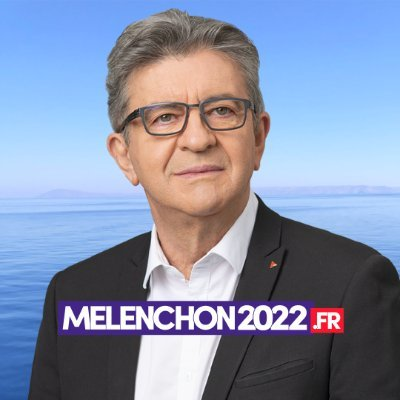

In [180]:
user_image(user="JLMelenchon")

In [181]:
def user_name(user):
    """
    Returns user's name
    """
    name = df_ready_for_nlp[df_ready_for_nlp["user"]==user]["name"].unique()[0]
    return name

In [183]:
user_name(user="JLMelenchon")

'Jean-Luc Mélenchon'

In [187]:
def user_political_party(user):
    """
    Returns user's political party
    """
    parti_politique = df_ready_for_nlp[df_ready_for_nlp["user"]==user]["political_party"].unique()[0]
    return parti_politique

In [188]:
user_political_party(user="JLMelenchon")

'la_france_insoumise'

In [189]:
def user_political_oritentation(user):
    """
    Return user's political orientation
    """
    orientation_politique = df_ready_for_nlp[df_ready_for_nlp["user"]==user]["political_trend"].unique()[0]
    return orientation_politique

In [190]:
user_political_oritentation(user="JLMelenchon")

'extrême_gauche'

## Ses thèmes de prédilection

In [46]:
def visualize_scores(df, user):
    # Generate user score per theme
    user_scores = list(df[df["user"]==user].drop(columns="political_trend").iloc[0])[1:]
    
    # Generate user political trend average score per theme
    user_political_trend = list(df[df["user"]==user]["political_trend"])[0]
    # Generate his/her name
    user_name = list(df[df["user"]==user]["name"])[0]
    # Generate a df with the avg score per political trend
    avg_score_per_political_trend = df.groupby(['political_trend']).mean()
    # Store the right political trend results in a variable
    political_trend_scores = list(avg_score_per_political_trend
                                  [avg_score_per_political_trend.index==user_political_trend]
                                  .iloc[0])
    
    # Generate national score per theme
    national_scores = list(avg_score_per_political_trend.mean())
    
    # Define themes
    themes = avg_score_per_political_trend.columns
    
    fig = go.Figure(data=[
                    go.Bar(name=f'{user_name} score', x=themes, y=user_scores),
                    go.Bar(name=f'{user_political_trend} score', x=themes, y=political_trend_scores),
                    go.Bar(name='National score', x=themes, y=national_scores)
                    ])
    
    # Change the bar mode
    fig.update_layout(barmode='group')
    
    fig.show()

In [129]:
visualize_scores(df=lexicon_score_per_user_df, user="JLMelenchon")

In [ ]:
# for political_user in list(df_ready_for_nlp["user"].unique()):
#     visualize_scores(df=lexicon_score_per_user_df, user=political_user)

## Les tweets les plus appréciés de sa communauté

In [48]:
def top_3_tweets_per_user(df, user):
    df = df.sort_values(by="retweet_count", ascending=False)
    
    df = df["text"][df["user"]==user]
    print("Premier tweet le plus retweeter:")
    print(df.iloc[0])
    print("-------------")
    print("Second tweet le plus retweeter:")
    print(df.iloc[1])
    print("-------------")
    print("Troisième tweet le plus retweeter:")
    print(df.iloc[2])

In [130]:
top_3_tweets_per_user(df=global_df, user="JLMelenchon")

Premier tweet le plus retweeter:
#Zemmour cité dans 230 articles par jour depuis deux mois. Sans compter les heures de télé. Impressionnante capacité des 9 milliardaires qui possèdent 90% de la presse à construire un paysage électoral à partir de rien. https://t.co/5ZBdU8hmO6
-------------
Second tweet le plus retweeter:
#Assange persécuté à mort. En prison, à l'isolement, menacé de mourir. En 2012, réfugié à l'ambassade d'Équateur, il a vécu 5ans dans 10 m2. Je l'y avais rencontré. Depuis des années nous réclamons son accueil en France. La France ne doit pas rester silencieuse. https://t.co/DO5q1Ivf9I
-------------
Troisième tweet le plus retweeter:
#Guyane
Samedi le recteur interdit ma rencontre avec les lycéens. Lundi la ministre Parly interdit les images de ma rencontre avec les militaires. S'ils pouvaient interdire mon bulletin de vote, ils le feraient.


## Les sujets qui l'animent

In [50]:
def top_five_words_per_theme_per_user(user):
    # Generate a list of all users
    list_of_users = list(df_ready_for_nlp["user"].unique())
    
    # Store all the user words in a list
    user_words = []
    # Extract all his/her tweets
    user_tweets = list(df_ready_for_nlp[df_ready_for_nlp["user"]==user]["text"])
    # Go for each tweet
    for tweet in user_tweets:
        for user in list_of_users:
            if user in tweet:
                user_words.append(user)
        # Tokenize each tweet to analyze its content
        tokenized_tweet = word_tokenize(tweet)
        # Go for each word
        for word in tokenized_tweet:
            # Append it to the list
            user_words.append(word)
    
    # For each vocabulary stored in lexicons check how many times it appears in user_words    
    # Define a list to store the top 5 words per lexicon
    top_five_words = []
    for theme, lexicon in lexicon_themes.items():
        test_dico ={}
        # For each word in the theme's lexicon
        for word in lexicon:
            # Count how many times it appears in user_words
            score = user_words.count(word)
            test_dico[word] = score
        sorted_list = sorted(test_dico.items(), key = lambda kv: kv[1], reverse=True)
        top_five_words.append(sorted_list)
        print(f"{theme} : {sorted_list[:5]}")

In [131]:
top_five_words_per_theme_per_user(user="JLMelenchon")

Politique : [('programme', 33), ('presidentielle', 27), ('droit', 21), ('politique', 19), ('etat', 19)]
Actualité : [('monde', 46), ('nucleaire', 23), ('droite', 19), ('jeunes', 17), ('candidat', 16)]
Candidats : [('melenchoneconomie', 80), ('melenchonlille', 41), ('macron', 38), ('melenchonessec', 35), ('melenchonbfmtv', 28)]
Travail : [('temps', 30), ('travail', 29), ('retraite', 19), ('travailler', 11), ('produit', 9)]
Santé : [('passsanitaire', 14), ('vie', 13), ('sanitaire', 10), ('constitution', 9), ('sante', 7)]
Economie : [('dette', 14), ('economique', 10), ('alimentaire', 10), ('impot', 10), ('crise', 9)]
Sécurité : [('probleme', 14), ('loi', 11), ('intervention', 9), ('securite', 8), ('police', 8)]
Extrême : [('puissance', 7), ('extreme', 6), ('haut', 5), ('risque', 4), ('extremement', 4)]
Ecologie : [('nucleaire', 23), ('ecologique', 16), ('energie', 14), ('nature', 6), ('generation', 3)]
Pouvoir_achat : [('prix', 20), ('retraite', 19), ('pauvrete', 7), ('consommation', 6), 